# EQUINE Pytorch Toy Problem Example

This notebook requires some extra dependencies to run. You can uncomment the below cell
to install them into your local environment.

In [1]:
#!pip install scikit-learn matplotlib

In [2]:
import equine as eq
import torch
import numpy as np
# Helpers for data generation
from sklearn.datasets import make_blobs
from sklearn.metrics import RocCurveDisplay
# Helpers for calculating expected calibration error (ECE)
from torchmetrics import Accuracy

import matplotlib.pyplot as plt

from equine import brier_score, brier_skill_score, expected_calibration_error

### Generate Toy Dataset
This dataset uses `make_blobs` from scikit-learn, placing 4 clusters in each 
quadrant (for 4 classes), along with a middle cluster with random class memberships.

In this toy problem, the accuracy should not be much higher than 80%, since the middle class memberships are essentially random.

Additionally, the class confidence in the middle of the problem should hover around 25% for the same reason.

Text(0.5, 1.0, 'Class membership of training data')

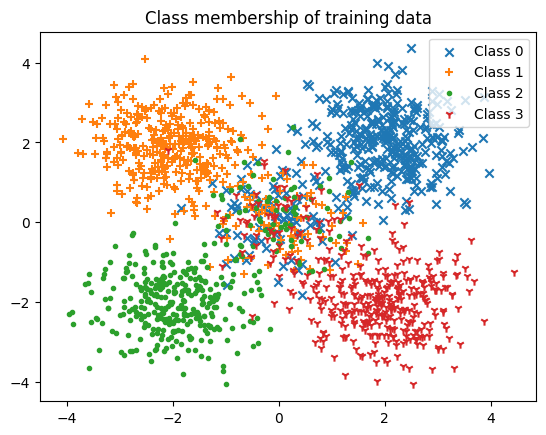

In [3]:
num_classes = 4
examples_per_class = 500
tensor_dim = 2

n_samples = examples_per_class * num_classes
centers = [ (2,2), (-2,2), (-2,-2), (2,-2), (0,0) ]
x_list, y_list = make_blobs(n_samples=n_samples, n_features=tensor_dim, 
                            centers=centers, cluster_std=0.75, shuffle=False,random_state=52)
# Randomize the classes in the middle
rng = np.random.default_rng(seed=52)
y_list[(n_samples*4//5):] = rng.integers(4, size=n_samples//5) 
X = torch.FloatTensor(x_list)
Y = torch.tensor(y_list)

dataset = torch.utils.data.TensorDataset(X,Y)
trainset, testset = torch.utils.data.random_split(dataset, [0.8, 0.2], 
                    generator=torch.Generator().manual_seed(52))
train_x = trainset.dataset.tensors[0][trainset.indices]
train_y = trainset.dataset.tensors[1][trainset.indices]
test_x  = testset.dataset.tensors[0][testset.indices]
test_y  = testset.dataset.tensors[1][testset.indices]

# Plot the training data
for class_i, marker in enumerate(["x", "+", ".", "1"]):
    xs = train_x[train_y == class_i]
    plt.scatter(xs[:,0], xs[:,1],marker=marker,label=f'Class {class_i}')
plt.legend(loc="best")
plt.title("Class membership of training data")

### Define our embedding model

Here we define a "usual" neural network architecture, leaving off only the softmax
in the forward function.

In [4]:
class EmbeddingModel(torch.nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(tensor_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, num_classes)
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# Note that we have left off the very last step (the softmax),
# so we'll need to apply that after the model to calculate "probabilities"

Next, we train a multiclass classification model in the usual way, using cross entropy loss and the Adam optimizer over 500 epochs (this should only take a few seconds)

In [5]:
vanilla_nn = EmbeddingModel()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vanilla_nn.parameters())

trainloader = torch.utils.data.DataLoader(trainset,batch_size=50,shuffle=True)

vanilla_nn.train()
for epoch in range(100):
    epoch_loss = 0.0
    for i, (xs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        yhats = vanilla_nn(xs)
        loss = loss_fn(yhats, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if epoch%50 == 49 or epoch == 0:
        print(f"Epoch {epoch+1} has loss {epoch_loss:3.2f}")

Epoch 1 has loss 44.21
Epoch 50 has loss 10.95
Epoch 100 has loss 10.66


Before we test the results, here are a few helper functions for printing out metrics like:
* Accuracy 
* Expected Calibration Error (ECE). Closest to zero is better, implying the NN output probabilities are well calibrated
* [Brier score](https://en.wikipedia.org/wiki/Brier_score), lower is better 
* [Brier skill score](https://en.wikipedia.org/wiki/Brier_score#Brier_Skill_Score_(BSS)), as compared to random guessing. Closer to 1.0 is better
We also evaluate the NN on a 2-D mesh and plot a contour map of background confidences

In [6]:
def display_2d_test_and_confidence(y_hat, x_test, y_test, Xt, Yt, confidences, title_in=None, num_classes=4):
    """
    Print out accuracy, expected calibration error, and render a 2-D plot

    :param y_hat: NN predictions on test data
    :param x_test: X data for testing
    :param y_test: one-hot encoded ground truth labels
    :param Xt: meshgrid of x locations
    :param Yt: meshgrid of y locations
    :param confidences: 2D torch tensor of confidences (scores between 0 and 1)
    :param title_in: Optional title for plot
    """
    # Plot class confidences on countourf and overlay test data predictions 
    y_out = torch.argmax(y_hat,1)
    fig, ax = plt.subplots()
    cf = ax.contourf(Xt.numpy(), Yt.numpy(), torch.reshape(confidences, [len(Xt),len(Yt)]), cmap=plt.cm.bone)
    fig.colorbar(cf, ax=ax)
    wrong_xs = torch.Tensor()
    markers = ["1", "+", ".", "o"] # 4-class default
    if num_classes == 5:
        markers = ["1", "+", ".", "o", "2"] 
    for class_i, marker in enumerate(markers):
        xs = x_test[(y_out == class_i) & (y_test == class_i)]
        wxs = x_test[(y_out == class_i) & (y_test != class_i)]
        wrong_xs = torch.cat((wrong_xs, wxs),0)
        ax.scatter(xs[:,0], xs[:,1],marker=marker,label=f'Class {class_i}')
    ax.scatter(wrong_xs[:,0], wrong_xs[:,1], marker="x", label="Incorrect")
    ax.legend()

    title = title_in
    if not title_in:
        title = "NN Test Predictions and Class Confidence"
    plt.title(title)


def print_metrics(y_hat, y_test, num_classes=4):
    """
    Print out accuracy, expected calibration error, and render a 2-D plot

    :param y_hat: NN predictions on test data
    :param y_test: one-hot encoded ground truth labels
    :param confidences: 2D torch tensor of confidences (scores between 0 and 1)
    """
    # Compute accuracy and ECE
    accuracy = Accuracy(task="multiclass", num_classes=num_classes, top_k=1)

    y_out = torch.argmax(y_hat,1)
    acc = accuracy(y_out, y_test)
    print(f"NN accuracy is {acc:3.2f}")
    
    ece = expected_calibration_error(y_hat, y_test)
    print(f"NN ECE is: {ece:3.2e}")
 
    bs = brier_score(y_hat, y_test)
    print(f"Brier score is: {bs:3.2e}")

    bss = brier_skill_score(y_hat, y_test)
    print(f"Brier skill score is: {bss:3.2f}")


Below we see that the vanilla neural network does fairly well on the test data for this problem, acheiving good accuracy, reasonably low ECE, and much better skill than random guessing. However, the predictive confidences remain high even far from the training data. 

NN accuracy is 0.84
NN ECE is: 3.56e-02
Brier score is: 1.86e-01
Brier skill score is: 0.75


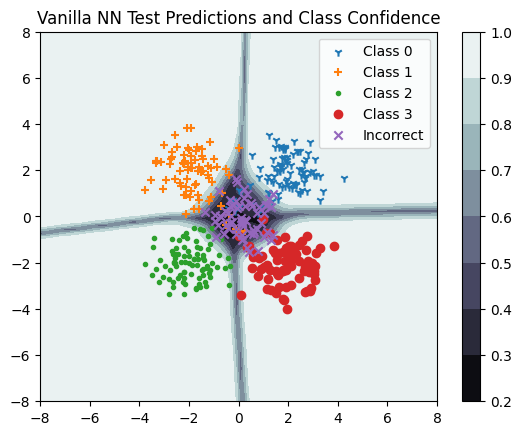

In [7]:
vanilla_nn.eval()
# Compute results on held-out test data
vanilla_results = torch.nn.Softmax(dim=1)(vanilla_nn(test_x))

# Compute confidence scores on a test grid
bbox = 8 
Xt, Yt = torch.meshgrid(torch.linspace(-bbox,bbox,steps=100), 
                        torch.linspace(-bbox,bbox,steps=100),
                        indexing='xy')
Xs = torch.cat(tuple(torch.dstack((Xt,Yt))))
vnn_results_grid=torch.nn.Softmax(dim=1)(vanilla_nn(Xs))
vnn_conf = torch.max(vnn_results_grid,1).values.detach()

# Evaluate the results
print_metrics(vanilla_results, test_y)
display_2d_test_and_confidence(vanilla_results, test_x, test_y, Xt, Yt, vnn_conf,
                            "Vanilla NN Test Predictions and Class Confidence" )

### Wrap the model using EQUINE
In order to have more reliable confidence overlays, and to have any chance of estimating an out-of-distribution score for each inference, we need to evaluate distances in the penultimate layer of the network. EQUINE provides a way to take an existing model and data, add layer(s) for distance embedding, and output new quantities for uncertainty quantification.

In [8]:
# Load weights from the trained model
sd = vanilla_nn.state_dict()
em = EmbeddingModel()
em.load_state_dict(sd)

# Pull out the feature embedding
all_layers = list(vanilla_nn.children())
embedding_layers = all_layers[0][:-1] # Remove the last layer
embedding_model = torch.nn.Sequential(*embedding_layers) # Rebuild the NN

# Create the EQUINE model, support examples, and pointers to those examples 
model = eq.EquineProtonet(embedding_model, emb_out_dim=16)
#model = eq.EquineProtonet(EmbeddingModel(), emb_out_dim=4) # Uncomment to restart "from scratch"

### Retrain or fine-tune EQUINE model with episodic training

To train a model, we use `train_episodes`, which has options explained below.

In [9]:
model.train_model(torch.utils.data.TensorDataset(train_x,train_y),
                    way=4,             # Number of classes to train each episode
                    support_size=20,           # Number of support examples per class each episode
                    num_episodes=1000, # Number of episodes (like epochs)
                    episode_size=100)  # Number training points selected per episode (like batches)

100%|██████████| 1000/1000 [00:01<00:00, 522.60it/s]


{'numTrainExamples': [{'label': 0, 'numExamples': 320},
  {'label': 1, 'numExamples': 328},
  {'label': 2, 'numExamples': 314},
  {'label': 3, 'numExamples': 318}],
 'dateTrained': '06/13/2023, 18:04:12',
 'modelType': 'EquineProtonet'}

### Evaluate the results
EQUINE introduces the "predict()" API to return predictions with the probability contexts, including
* classes:    the class probabilities
* ood_scores: the out-of-distribution scores
as well as other variables

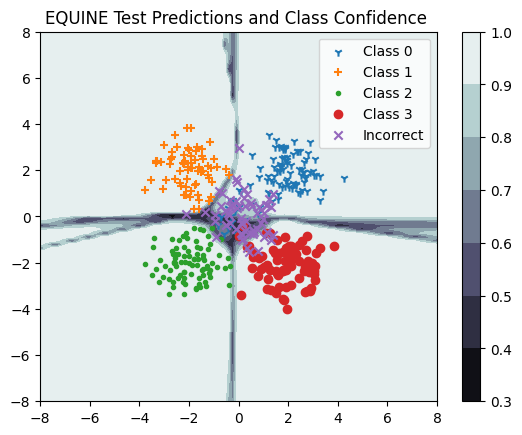

In [10]:
# Evaluate for the held-out test data and on the 2-D mesh
model.eval()
proto_results=model.predict(test_x)
yhat = proto_results.classes

proto_grid_results=model.predict(Xs)
y_conf = torch.max(proto_grid_results.classes,1).values.detach()
display_2d_test_and_confidence(yhat, test_x, test_y, Xt, Yt, y_conf, "EQUINE Test Predictions and Class Confidence ")

Here's an example of the OOD scores, which is supposed to indicate that, far away from the
training data, the predictions are more likely to be out-of-distribution (scores should approach 1.0), 

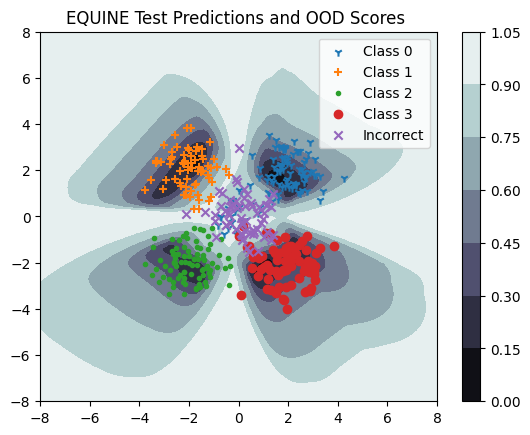

In [11]:
y_ood  = torch.FloatTensor(proto_grid_results.ood_scores)
display_2d_test_and_confidence(yhat, test_x, test_y, Xt, Yt, y_ood, "EQUINE Test Predictions and OOD Scores ")

### Adding Out-Of-Distribution Data 
In this section, we add a new cluster of data just to the right of the existing data to showcase how one could use the "ood_score" attribute of `EquineOutput`.


In [12]:
new_x, _ = make_blobs(n_samples=100, n_features=tensor_dim, 
                        centers=[[6,0]], cluster_std=0.5, shuffle=False,random_state=52)
class4_Xs = torch.FloatTensor(new_x)
class4_Ys = 4*torch.ones(len(new_x),dtype=torch.int)    

# Append to existing test data
ood_test_x = torch.cat((test_x, class4_Xs))
ood_test_y = torch.cat((test_y, class4_Ys))

Neither the vanilla neural network or the EQUINE network knows "out of distribution" cluster, so it's impossible for the networks to correctly predict the new label -- meaning that the cluster appears as a bunch of wrong predictions to the right of the existing test data.

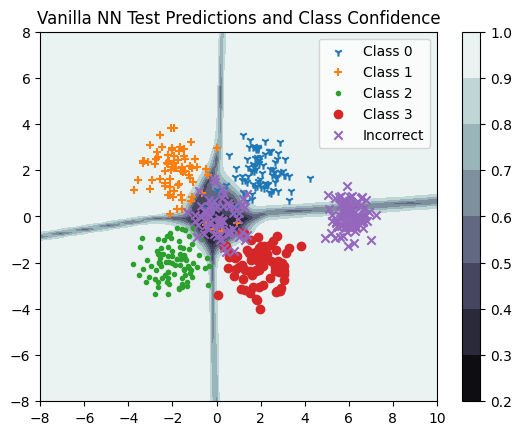

In [13]:
# Compute new results with appended OOD cluster
vanilla_results = torch.nn.Softmax(dim=1)(vanilla_nn(ood_test_x))
vnn_conf_pts = torch.max(vanilla_results,1).values.detach()
vnn_y_classes = torch.argmax(vanilla_results,1)

# Extend the grid to the right a bit to see the new cluster
bbox = 8 
Xt, Yt = torch.meshgrid(torch.linspace(-bbox,bbox+2,steps=100), 
                        torch.linspace(-bbox,bbox,steps=100),
                        indexing='xy')
Xs = torch.cat(tuple(torch.dstack((Xt,Yt))))
vnn_results_grid=torch.nn.Softmax(dim=1)(vanilla_nn(Xs))
vnn_conf = torch.max(vnn_results_grid,1).values.detach()

display_2d_test_and_confidence(vanilla_results, ood_test_x, ood_test_y, Xt, Yt, vnn_conf,
                            "Vanilla NN Test Predictions and Class Confidence")

Finally, we illustrate the binary predictive performance on "correct" and "incorrect" predictions that would come from using the OOD scores to screen out predictions on likely OOD data. To do this, we'll generate a ROC curve using 1-OOD scores (something like an "in-distribution" score) as a confidence threshold for EQUINE, and the maximum probability for the vanilla Neural Network.  Note that these ROC curves could be made arbitrarily more unfavorable to the Vanilla Neural Network by adding more OOD test points and/or more OOD data clusters; the point is just to show how EQUINE's `ood_scores` can be used to filter out predictions on OOD data. 

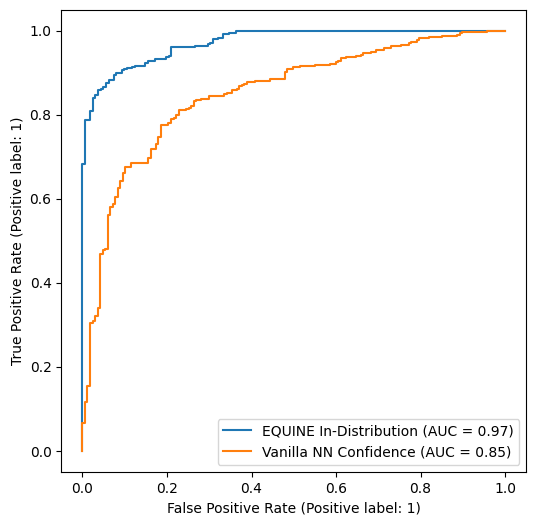

In [14]:
# Let's see how well the confidence does at figuring ou
vnn_correct = (vnn_y_classes == ood_test_y)

# Generate results for the EQUINE protonet
proto_results=model.predict(ood_test_x)
eq_y_classes = torch.argmax(proto_results.classes,1)
eq_correct = (eq_y_classes == ood_test_y)

# Show the performance 
fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(eq_correct, 1.0-proto_results.ood_scores, name="EQUINE In-Distribution", ax=ax)
RocCurveDisplay.from_predictions(vnn_correct, vnn_conf_pts, name="Vanilla NN Confidence", ax=ax)

### Bonus Protonet result (few-shot learning)
Protonets are able to add additional classes without retraining! We next show how the OOD scores and confidences change when this happens. In the below cells, we generate some new "support" examples by randomly sampling 30 examples of each class, including the new class, and then using that to update the EquineProtonet model. 


In [15]:
# Generate some support for the OOD class so as not to overlap with the test data
new_x, _ = make_blobs(n_samples=100, n_features=tensor_dim, 
                        centers=[[6,0]], cluster_std=0.5, shuffle=False,random_state=52)
class4_Xs = torch.FloatTensor(new_x)
class4_Ys = 4*torch.ones(len(new_x),dtype=torch.int) 
ood_train_x= torch.cat((train_x, class4_Xs))
ood_train_y = torch.cat((train_y, class4_Ys))

# Randomly pull 30 examples from each class in the training data to use as support and for prototypes
support_size = 30
new_support_dict = eq.utils.generate_support(ood_train_x, ood_train_y, 
                    support_size=support_size, selected_labels=list(range(5)))
support_x = torch.concat(tuple(new_support_dict.values()))
support_y = torch.Tensor([support_size*[i] for i in range(5)]).ravel()

model.update_support(support_x, support_y, 0.33) # This uses 1/3 of the data to calibrate the OOD scores

Having updated the support, we can now do more predictions without having to retrain.

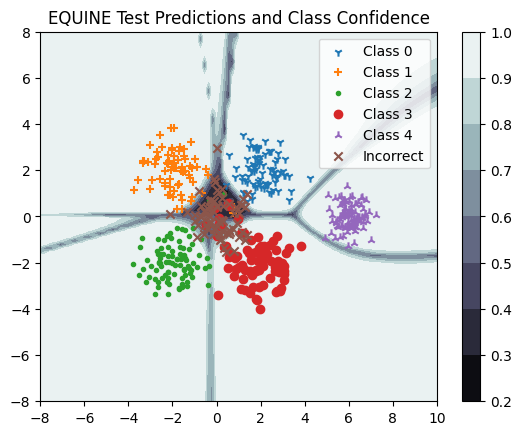

In [16]:
proto_results=model.predict(ood_test_x)
yhat = proto_results.classes
proto_grid_results = model.predict(Xs)
y_conf = torch.max(proto_grid_results.classes,1).values.detach()
display_2d_test_and_confidence(yhat, ood_test_x, ood_test_y, Xt, Yt, y_conf, "EQUINE Test Predictions and Class Confidence", num_classes=5)

The new class has shifted the class confidence boundaries. Furthermore, the OOD scores for the new class are now lower:

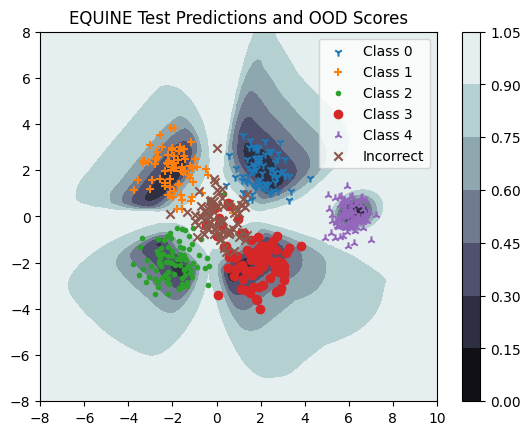

In [17]:
y_ood  = torch.FloatTensor(proto_grid_results.ood_scores)
display_2d_test_and_confidence(yhat, ood_test_x, ood_test_y, Xt, Yt, y_ood, "EQUINE Test Predictions and OOD Scores",num_classes=5)